#Tutorial 5 - Options Intro

Please complete this tutorial to get an overview of options and an implementation of SMDP Q-Learning and Intra-Option Q-Learning.


### References:

 [Recent Advances in Hierarchical Reinforcement
Learning](https://people.cs.umass.edu/~mahadeva/papers/hrl.pdf) is a strong recommendation for topics in HRL that was covered in class. Watch Prof. Ravi's lectures on moodle or nptel for further understanding the core concepts. Contact the TAs for further resources if needed. 


In [83]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import gym
from gym.wrappers import Monitor
import glob
import io
import matplotlib.pyplot as plt
from IPython.display import HTML

In [84]:
def plot_Q(Q, message = "Q plot"):
    
    plt.figure(figsize=(10,10))
    plt.title(message)
    plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
    plt.colorbar()
    def x_direct(a):
        if a in [0, 2, 4, 5]:
            return 0
        return 1 if a == 1 else -1
    def y_direct(a):
        if a in [1, 3]:
            return 0
        return 1 if (a == 0 or a == 4) else -1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    plt.show()

def plot_visits(visits, message = "Average visits to each state"):
    plt.figure(figsize=(10,10))
    plt.title(message)
    plt.pcolor(visits, edgecolors='k', linewidths=2)
    plt.colorbar()
    plt.show()

In [85]:
'''
The environment used here is extremely similar to the openai gym ones.
At first glance it might look slightly different. 
The usual commands we use for our experiments are added to this cell to aid you
work using this environment.
'''

#Setting up the environment
from gym.envs.toy_text.cliffwalking import CliffWalkingEnv
env = CliffWalkingEnv()

env.reset()

#Current State
print(env.s)

# 4x12 grid = 48 states
print ("Number of states:", env.nS)

# Primitive Actions
action = ["up", "right", "down", "left"]
#correspond to [0,1,2,3] that's actually passed to the environment

# either go left, up, down or right
print ("Number of actions that an agent can take:", env.nA)

# Example Transitions
rnd_action = random.randint(0, 3)
print ("Action taken:", action[rnd_action])
next_state, reward, is_terminal, t_prob = env.step(rnd_action)
print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)
env.render()

36
Number of states: 48
Number of actions that an agent can take: 4
Action taken: down
Transition probability: {'prob': 1.0}
Next state: 36
Reward recieved: -1
Terminal state: False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



#### Options
We custom define very simple options here. They might not be the logical options for this settings deliberately chosen to visualise the Q Table better.


In [106]:
# We are defining two more options here
# Option 1 ["Away"] - > Away from Cliff (ie keep going up)
# Option 2 ["Close"] - > Close to Cliff (ie keep going down) 

def Away(env,state):
    
    optdone = False
    optact = 0
    
    if (int(state/12) <= 1): # To make the training faster, we end the option once the agent moves one step away from the cliff. In all other states, the agent moves up
        optdone = True
    
    return [optact,optdone]
    
def Close(env,state):
    
    optdone = False
    optact = 2
    
    if (int(state/12) >= 2): # To avoid an infinite loop, we also end the option once the agent moves into the cliff from the edge. In all other states, the agent moves down
        optdone = True
    
    return [optact,optdone]
    
    
'''
Now the new action space will contain
Primitive Actions: ["up", "right", "down", "left"]
Options: ["Away","Close"]
Total Actions :["up", "right", "down", "left", "Away", "Close"]
Corresponding to [0,1,2,3,4,5]
'''

'\nNow the new action space will contain\nPrimitive Actions: ["up", "right", "down", "left"]\nOptions: ["Away","Close"]\nTotal Actions :["up", "right", "down", "left", "Away", "Close"]\nCorresponding to [0,1,2,3,4,5]\n'

# Task 1
Complete the code cell below


In [123]:
rg = np.random.RandomState(42)
#Q-Table: (States x Actions) === (env.ns(48) x total actions(6))
q_values_SMDP = np.zeros((48,6))
q_updates_SMDP = np.zeros((48, 6))
#Update_Frequency Data structure? Check TODO 4

# TODO: epsilon-greedy action selection function
def egreedy_policy(Q, state, epsilon):
  if not Q[state].any() or rg.rand() < epsilon:
        return rg.choice(Q.shape[-1])
  else:
        return np.argmax(Q[state])

# Task 2
Below is an incomplete code cell with the flow of SMDP Q-Learning. Complete the cell and train the agent using SMDP Q-Learning algorithm.
Keep the **final Q-table** and **Update Frequency** table handy (You'll need it in TODO 4)

In [ ]:
#### SMDP Q-Learning 

# Add parameters you might need here
gamma = 0.99
alpha = 0.02
rewards_SMDP = []
# Iterate over 1000 episodes
for ep in range(2000):
    state = env.reset()    
    done = False
    r = 0
    # While episode is not over
    while not done:
        # Choose action        
        action = egreedy_policy(q_values_SMDP, state, epsilon=0.1)
        
        # Checking if primitive action
        if action < 4:
            # Perform regular Q-Learning update for state-action pair
            next_state, reward, done, _ = env.step(action)
            q_values_SMDP[state, action] = q_values_SMDP[state, action] + alpha*(reward + gamma*np.max(q_values_SMDP[next_state, :]) - q_values_SMDP[state, action])
            q_updates_SMDP[state, action] += 1
            state = next_state
            r += reward
            continue
        # Checking if action chosen is an option
        reward_bar = 0
        if action == 4: # action => Away option
            curr_state = state
            optdone = False
            n = 1
            while (optdone == False):
                # Think about what this function might do?
                optact, optdone = Away(env, state) 
                next_state, reward, done,_ = env.step(optact)
                
                # Is this formulation right? What is this term?
                reward_bar = reward_bar + (gamma**(n - 1))*reward
                n += 1
                state = next_state
                r += reward
            # Complete SMDP Q-Learning Update
            q_values_SMDP[curr_state, action] = q_values_SMDP[curr_state, action] + alpha*(reward_bar + (gamma**n)*np.max(q_values_SMDP[state, :]) - q_values_SMDP[curr_state, action])
            q_updates_SMDP[curr_state, action] += 1
            # Remember SMDP Updates. When & What do you update?  
            continue 
        if action == 5: # action => Close option
            curr_state = state
            optdone = False
            n = 1
            while (optdone == False):
                # Think about what this function might do?
                optact, optdone = Close(env, state) 
                next_state, reward, done,_ = env.step(optact)
                
                # Is this formulation right? What is this term?
                reward_bar = reward_bar + (gamma**(n - 1))*reward
                n += 1
                state = next_state
                r += reward
            # Complete SMDP Q-Learning Update
            q_values_SMDP[curr_state, action] = q_values_SMDP[curr_state, action] + alpha*(reward_bar + (gamma**n)*np.max(q_values_SMDP[state, :]) - q_values_SMDP[curr_state, action])
            q_updates_SMDP[curr_state, action] += 1
            continue
    rewards_SMDP.append(r)    

# Task 3
Using the same options and the SMDP code, implement Intra Option Q-Learning (In the code cell below). You *might not* always have to search through options to find the options with similar policies, think about it. Keep the **final Q-table** and **Update Frequency** table handy (You'll need it in TODO 4)



In [125]:
#Q-Table: (States x Actions) === (env.ns(48) x total actions(6))
q_values_IO = np.zeros((48,6))
q_updates_IO = np.zeros((48,6))

In [126]:
#### Intra-Option Q-Learning 
# Add parameters you might need here
gamma = 0.99
alpha = 0.02
rewards_IO = []
# Iterate over 1000 episodes
for ep in range(2000):
    state = env.reset()    
    done = False
    # While episode is not over
    r = 0
    while not done:
        # Choose action        
        action = egreedy_policy(q_values_IO, state, epsilon=0.1)
        if action < 4:
          next_state, reward, done, _ = env.step(action)
          if action == 0:
            q_values_IO[state, action] = q_values_IO[state, action] + alpha*(reward + gamma*np.max(q_values_IO[next_state, :]) - q_values_IO[state, action])
            q_values_IO[state, 4] = q_values_IO[state, 4] + alpha*(reward + gamma*q_values_IO[next_state, 4] - q_values_IO[state, 4])
            q_updates_IO[state, action] += 1
            q_updates_IO[state, 4] += 1
            state = next_state
          elif action == 2:
            q_values_IO[state, action] = q_values_IO[state, action] + alpha*(reward + gamma*np.max(q_values_IO[next_state, :]) - q_values_IO[state, action])
            q_values_IO[state, 5] = q_values_IO[state, 5] + alpha*(reward + gamma*q_values_IO[next_state, 5] - q_values_IO[state, 5])
            q_updates_IO[state, action] += 1
            q_updates_IO[state, 5] += 1
            state = next_state
          else:
            q_values_IO[state, action] = q_values_IO[state, action] + alpha*(reward + gamma*np.max(q_values_IO[next_state, :]) - q_values_IO[state, action])
            q_updates_IO[state, action] += 1
            state = next_state
        elif action == 4:
          optact, optdone = Away(env, state) 
          next_state, reward, done, _ = env.step(optact)
          if optdone:
            q_values_IO[state, action] = q_values_IO[state, action] + alpha*(reward + gamma*np.max(q_values_IO[next_state, :]) - q_values_IO[state, action])
          else:
            q_values_IO[state, 4] = q_values_IO[state, 4] + alpha*(reward + gamma*q_values_IO[next_state, 4] - q_values_IO[state, 4])
          q_values_IO[state, 0] = q_values_IO[state, 0] + alpha*(reward + gamma*q_values_IO[next_state, 0] - q_values_IO[state, 0])
          q_updates_IO[state, action] += 1
          q_updates_IO[state, 0] += 1
          state = next_state
        else:
          optact, optdone = Close(env, state) 
          next_state, reward, done, _ = env.step(optact)
          if optdone:
            q_values_IO[state, action] = q_values_IO[state, action] + alpha*(reward + gamma*np.max(q_values_IO[next_state, :]) - q_values_IO[state, action])
          else:
            q_values_IO[state, 5] = q_values_IO[state, 5] + alpha*(reward + gamma*q_values_IO[next_state, 5] - q_values_IO[state, 5])
          q_values_IO[state, 2] = q_values_IO[state, 2] + alpha*(reward + gamma*q_values_IO[next_state, 2] - q_values_IO[state, 2])
          q_updates_IO[state, action] += 1
          q_updates_IO[state, 2] += 1
          state = next_state
        r += reward
    rewards_IO.append(r)

# Task 4
Compare the two Q-Tables and Update Frequencies and provide comments.

Text(0.5, 1.0, 'Reward Curve - Intra Option Q-learning')

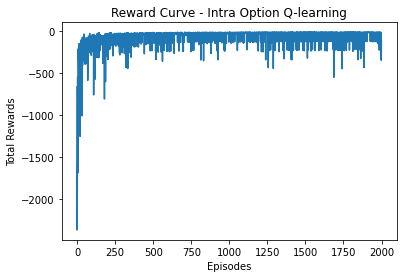

In [127]:
plt.plot(rewards_IO)
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('Reward Curve - Intra Option Q-learning')

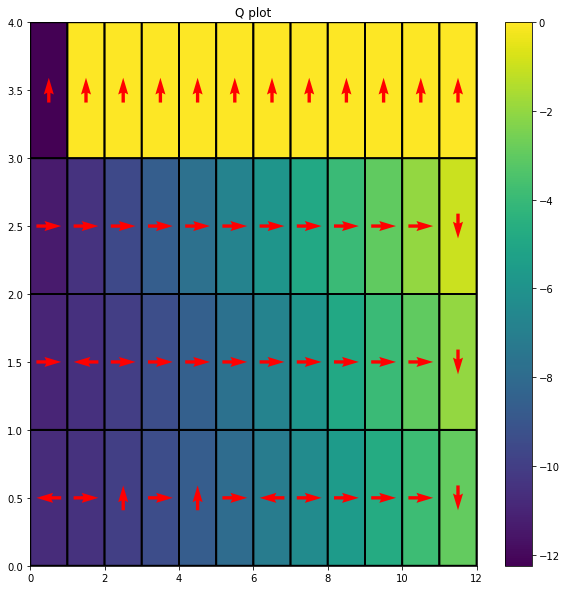

In [128]:
plot_Q(q_values_IO.reshape((4, 12, 6)))

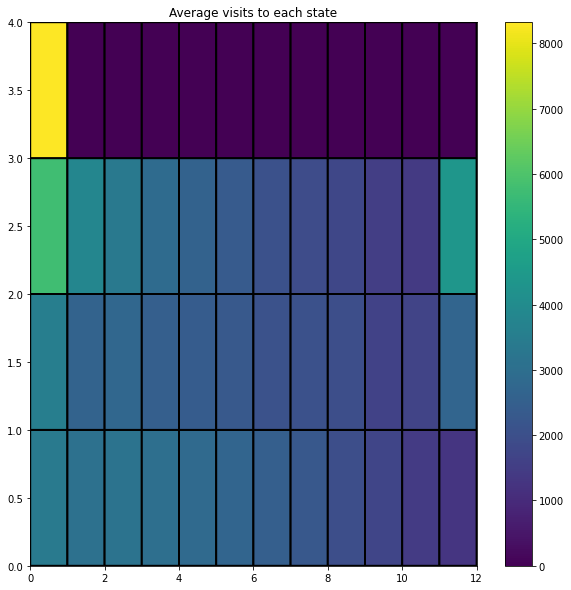

In [129]:
plot_visits(np.sum(q_updates_IO, axis = -1).reshape((4, 12)))

Text(0.5, 1.0, 'Reward Curve - SMDP Q-learning')

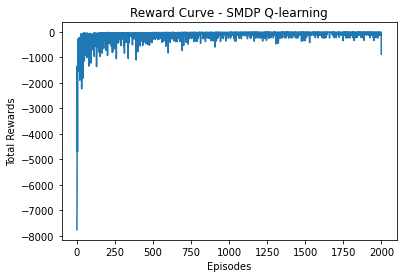

In [130]:
plt.plot(rewards_SMDP)
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('Reward Curve - SMDP Q-learning')

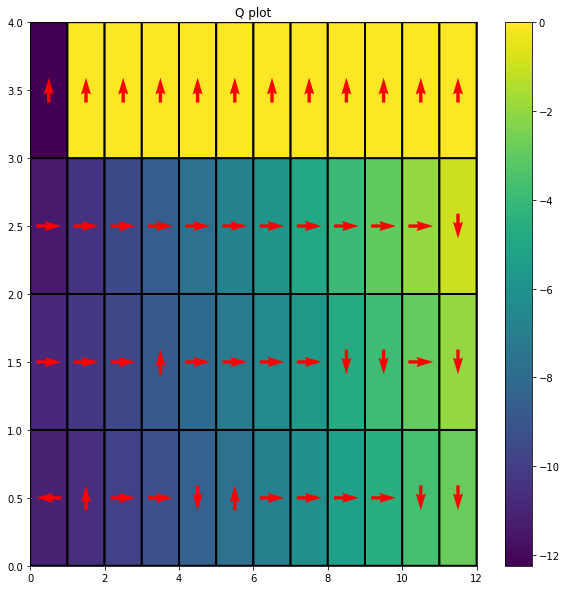

In [131]:
plot_Q(q_values_SMDP.reshape((4, 12, 6)))

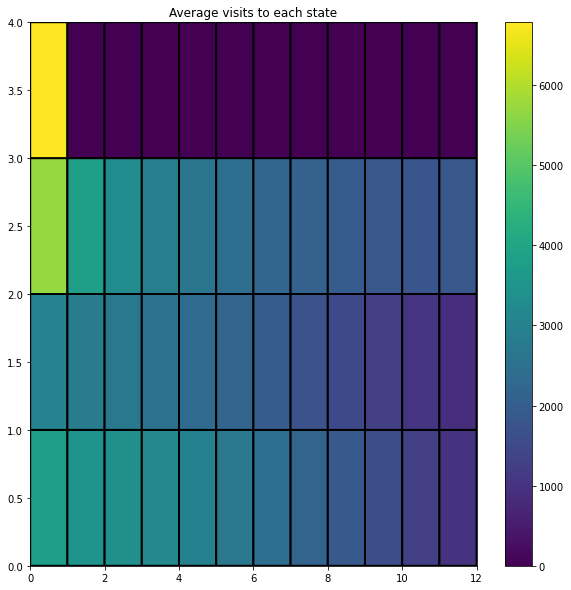

In [132]:
plot_visits(np.sum(q_updates_SMDP, axis = -1).reshape((4, 12)))

Inferences:
From the update frequency, we can see that the frequency of SMDP Q-learning updates are less when compared to that of Intra-option Q-learning. This is because for a single step, SMDP Q-learning might not do any updates at all, since the option needs to end. From the reward curve, the variance in the rewards is much less for SMDP Q-learning.On the other hand, there is considerable variance in the total rewards for Intra-option Q-learning. The optimal policies obtained from both the algorithms look similar in almost all the states. We can see that the cliff has been avoided by both the policies (The number of updates in that state is very less).
